In [ ]:
#imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from getdata import coordskpc, masssolar

unitless first draft of plotting (and computing) the density profile for given points.

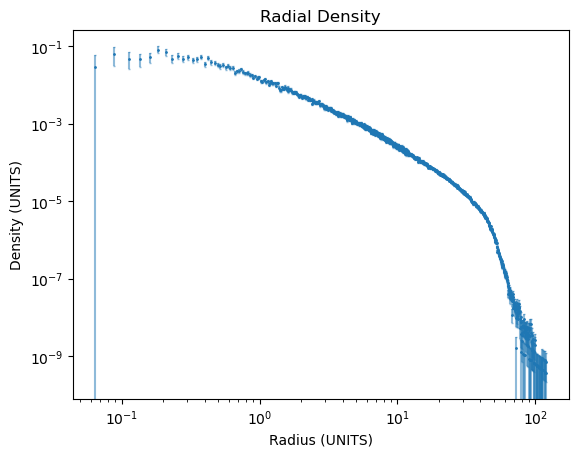

In [3]:
data = h5py.File("cutout_598597.hdf5", 'r')

coords = np.array(data["PartType1"]["Coordinates"])
coordsx = coords[:,0]
coordsy = coords[:,1]
coordsz = coords[:,2]

#all particles have the same mass, so the centre of mass is mass independent.
masstable = data["Header"].attrs["MassTable"]
particle_mass = masstable[1]

def plot_density_profile_unitless(coords, particle_mass, nr_bins=1000):
    com_coord = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - com_coord
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))
    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    
    #linear for small radius and log for large radius, while avoiding overlap
    bins_linear = np.linspace(r_min, r_max / 10, nr_bins // 2 + 1)  
    bins_log = np.logspace(np.log10(r_max / 10), np.log10(r_max), nr_bins // 2 + 1)  
    bins = np.concatenate([bins_linear, bins_log[1:]])  
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)

    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*particle_mass / bin_volume
    bin_poisson_error = np.sqrt(bin_counts)*particle_mass / bin_volume

    plt.scatter(bin_centre, bin_density, s=1)
    plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.5)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Radius (UNITS)")
    plt.ylabel("Density (UNITS)")
    plt.title("Radial Density")
    plt.show()

plot_density_profile_unitless(coords, particle_mass)

Units conversion for density profile:

In [4]:
data = h5py.File("cutout_598597.hdf5", 'r')

coords = np.array(data["PartType1"]["Coordinates"])
particle_mass = masstable[1]

masstable = data["Header"].attrs["MassTable"]
unitlength_cm = data["Header"].attrs["UnitLength_in_cm"]
hubble_param = data["Header"].attrs["HubbleParam"]

print("unit mass in grams: " + str(particle_mass))
print("unit length in cm: " + str(unitlength_cm))
print("Hubble parameter: " + str(hubble_param))

coords_kpc = (coords / hubble_param) * units.kpc
mass = (particle_mass / hubble_param) * 1e10 * units.Msun

print("mass unit: " + str(mass.unit))

unit mass in grams: 3.6475560966083303e-05
unit length in cm: 3.085678e+21
Hubble parameter: 0.6774
mass unit: solMass


small test to see how numpy operations can be done with astropy.

In [5]:
def volume_units(radius_unitlength, hubble_param):
    radius_kpc = (radius_unitlength/hubble_param) * units.kpc
    return (4/3)*np.pi*(radius_kpc**3)

#print(volume_units(50, 0.7))
#print(volume_units(np.linspace(1, 20, 200), 0.7))
x = np.linspace(1, 5, 5)*units.kpc
print("before log10: " + str(x) + "\nafter log10:  " + str(np.log10(x.value)*x.unit))

before log10: [1. 2. 3. 4. 5.] kpc
after log10:  [0.         0.30103    0.47712125 0.60205999 0.69897   ] kpc


Test for importing functions from python file, containing useful functions:

In [10]:
coords = getdata.coordskpc()
mass = getdata.masssolar()

print("some coordinates: " + str(coords[:2,:]))
print("particle mass: " + str(mass))

some coordinates: [[33208.91186209 10905.22025905 40987.16672691]
 [33208.63456443 10905.00501869 40987.36385054]] kpc
particle mass: 538464.1418081385 solMass


density function:

In [48]:
def getdensityprofile(nr_bins = 1000, bin_distr = "logarithmic"):
    bin_distr_options = ["linear", "logarithmic"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))
    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins)

    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit

    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2

    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume
    bin_poisson_error = np.sqrt(bin_counts)*mass / bin_volume

    return bin_centre, bin_density, bin_poisson_error

density profile calculated.


In [55]:
#example showing it working:
bcentre, bdensity, bpoissonerror = getdensityprofile()
print("a bin centre:        " + str(bcentre[-1:]) + "\na bin density        " + str(bdensity[-1:]) + "\na bin poisson error: " + str(bpoissonerror[-1:]))

density profile calculated.
a bin centre:        [176.92956907] kpc
a bin density        [1.99720284] solMass / kpc3
a bin poisson error: [1.41223567] solMass / kpc3
